# Predicting QoS using Machine Learning

## Data Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed_val = 1
from numpy.random import seed
seed(seed_val)
from tensorflow import set_random_seed
set_random_seed(seed_val)

In [3]:
# Importing the dataset
dataset = pd.read_csv('serverless_data.csv')
dataset['tp_normalized'] = dataset.apply(lambda x: x['completed_post'] / x['completed_profile'] , axis=1)

filtered_rows = dataset['tp_normalized'] > 10
filtered_rows |= dataset['failed_post'] > 0
filtered_rows |= dataset['failed_profile'] > 0

target_columns = ['cpu_idle-avg_post', 'cpu_io_wait-avg_post', 'cpu_krn-avg_post', 'cpu_sint_time-avg_post',
                 'cpu_usr-avg_post', 'dsr-avg_post', 'dsreads-avg_post', 'dsw-avg_post', 'dswrites-avg_post',
                 'dwm-avg_post', 'mem_used_pct-avg_post', 'nbr-avg_post', 'nbs-avg_post', 'readtime-avg_post',
                 'writetime-avg_post', ]

predictor_columns = ['cpu_idle-avg_pre', 'cpu_idle-avg_profile', 'cpu_io_wait-avg_pre',
                    'cpu_io_wait-avg_profile', 'cpu_usr-avg_pre', 'cpu_usr-avg_profile', 
                    'dsreads-avg_pre', 'dsreads-avg_profile', 'dswrites-avg_pre', 
                    'dswrites-avg_profile', 'mem_used_pct-avg_pre',
                    'mem_used_pct-avg_profile', 'nbr-avg_pre', 'nbr-avg_profile', 'nbs-avg_pre', 'nbs-avg_profile',
                    'readtime-avg_pre', 'readtime-avg_profile', 'writetime-avg_pre', 'writetime-avg_profile', ]

dataset = dataset.loc[np.logical_not(filtered_rows),predictor_columns + ['tp_normalized']]

In [4]:
dataset.shape

(183, 21)

In [5]:
# Get the predictors and the target variables
X = dataset.iloc[:, :-1].values
y = dataset.loc[:, "tp_normalized"].values

In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train[:,np.newaxis])
y_train = y_train.reshape(1,-1)[0,:]

# We shouldn't transform the y_test since we will run tests on the original domain
# We should transfer the predictions back to the main space

X = sc_X.transform(X)
y = sc_y.fit_transform(y[:,np.newaxis])
y = y.reshape(1,-1)[0,:]

In [8]:
def get_adjusted_r_squared(y, yhat):
    # compute with formulas from the theory
    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return adjusted_r_squared

def evaluate_results(y_test, y_pred):
    plt.plot(y_pred)
    plt.plot(y_test)
    plt.legend(['Prediction', 'Truth'])
    plt.title('Normalized Throughput')
    plt.xlabel('Sample #')
    plt.ylabel('Normalized Throughput')

    from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
    
    my_r2_score = r2_score(y_test, y_pred)
    my_r2_score_adj = get_adjusted_r_squared(y_test, y_pred)
    my_mean_squared_error = mean_squared_error(y_test, y_pred)
    my_explained_variance_score = explained_variance_score(y_test, y_pred)
    my_correlation = np.corrcoef(y_pred.flatten(), y_test.flatten())[0,1]
    
    print("r2_score: ", my_r2_score)
    print("MSE: ", my_mean_squared_error)
    print("Correlation: ", my_correlation)
    print("ajd r2_score: ", my_r2_score_adj)
    print("RMSE: ", np.sqrt(my_mean_squared_error))
    print("explained_variance_score: ", my_explained_variance_score)
    
    return my_r2_score, my_mean_squared_error, my_explained_variance_score

r2_score:  0.8025316223075217
MSE:  0.009751098853629288
Correlation:  0.9104582919998111
ajd r2_score:  0.6863737530766522
RMSE:  0.09874765239553439
explained_variance_score:  0.8078263431567031


(0.8025316223075217, 0.009751098853629288, 0.8078263431567031)

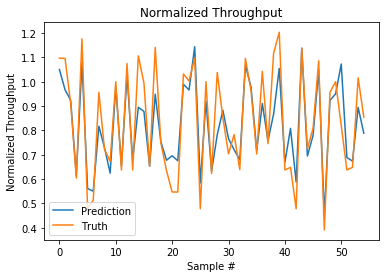

In [10]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

evaluate_results(y_test, y_pred)

r2_score:  0.8025316223075233
MSE:  0.009751098853629212
Correlation:  0.9104582919998119
ajd r2_score:  0.6863737530766546
RMSE:  0.098747652395534
explained_variance_score:  0.807826343156703


(0.8025316223075233, 0.009751098853629212, 0.807826343156703)

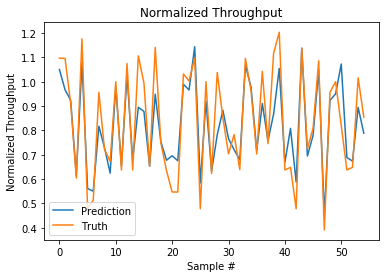

In [9]:
# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Get additional validation set
X_train2, X_validate, y_train2, y_validate = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

# Train and validate
n_alphas = 200
alphas = np.append(0, np.logspace(-10, -2, n_alphas))

min_mse = float("inf")
min_a = 0
for a in alphas:
    regressor = Ridge(alpha=a)
    regressor.fit(X_train2, y_train2)
    
    y_pred = regressor.predict(X_validate)
    y_pred = sc_y.inverse_transform(y_pred)
    
    my_mse = mean_squared_error(y_validate, y_pred)
    if my_mse < min_mse:
        min_mse = my_mse
        min_a = a
        
regressor = Ridge(alpha=min_a)
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

evaluate_results(y_test, y_pred)

r2_score:  0.9028141350214225
MSE:  0.004799092328886211
Correlation:  0.954028112029218
ajd r2_score:  0.8456459791516711
RMSE:  0.06927548144102798
explained_variance_score:  0.9044220054757419


(0.9028141350214225, 0.004799092328886211, 0.9044220054757419)

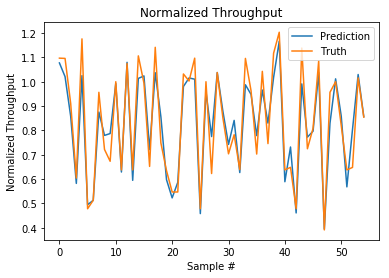

In [11]:
from sklearn.svm import SVR

estimator = SVR(gamma='auto')
estimator = estimator.fit(X_train, y_train)

# Predicting the Test set results
y_pred = estimator.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

# Evaluate the results
evaluate_results(y_test, y_pred)

r2_score:  0.42740633464570976
MSE:  0.02827499521228045
Correlation:  0.6593844804566513
ajd r2_score:  0.09058653149612705
RMSE:  0.16815170297169293
explained_variance_score:  0.42849743384778916


(0.42740633464570976, 0.02827499521228045, 0.42849743384778916)

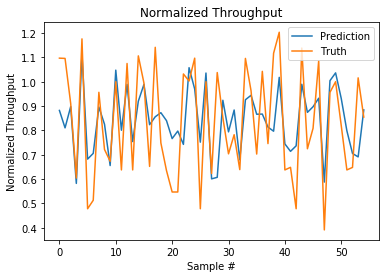

In [12]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train, y_train)

# Predicting the Test set results
y_pred = selector.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

# Evaluate the results
evaluate_results(y_test, y_pred)

r2_score:  0.45107080806228683
MSE:  0.02710643028912357
Correlation:  0.6722596948306302
ajd r2_score:  0.12817128339304373
RMSE:  0.16464030578544117
explained_variance_score:  0.4518665628610713


(0.45107080806228683, 0.02710643028912357, 0.4518665628610713)

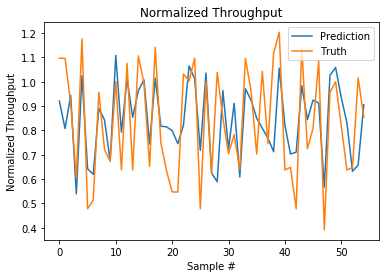

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# estimator = LinearRegression()
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X_train, y_train)

estimator = SVR(kernel="linear")
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X_train, y_train)


# # Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(selector.transform(X_train))
poly_reg.fit(X_poly, y_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

# Predicting the Test set results
y_pred = lin_reg_2.predict(poly_reg.fit_transform(selector.transform(X_test)))
y_pred = sc_y.inverse_transform(y_pred)

# Evaluate the results
evaluate_results(y_test, y_pred)

r2_score:  0.9005757182279773
MSE:  0.004909626601176127
Correlation:  0.9537648407691081
ajd r2_score:  0.8420908465973758
RMSE:  0.07006872769771211
explained_variance_score:  0.9093700417045286


(0.9005757182279773, 0.004909626601176127, 0.9093700417045286)

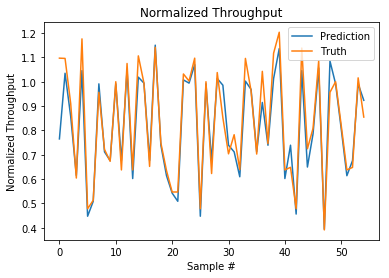

In [14]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

# Evaluate the results
evaluate_results(y_test, y_pred)

r2_score:  0.8990858653919729
MSE:  0.004983196366882428
Correlation:  0.9621284849003826
ajd r2_score:  0.8397246097401923
RMSE:  0.07059175849121785
explained_variance_score:  0.9087426270843495


(0.8990858653919729, 0.004983196366882428, 0.9087426270843495)

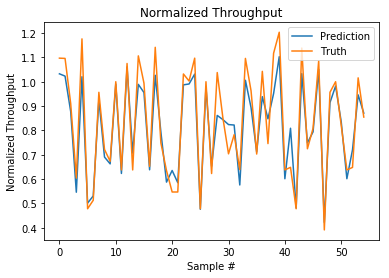

In [15]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred = sc_y.inverse_transform(y_pred)

# Evaluate the results
evaluate_results(y_test, y_pred)

Using TensorFlow backend.


r2_score:  0.9308794786876395
MSE:  0.0034132099731981063
Correlation:  0.9704917307208194
ajd r2_score:  0.8902203485038981
RMSE:  0.058422683721291904
explained_variance_score:  0.9391824543593088


(0.9308794786876395, 0.0034132099731981063, 0.9391824543593088)

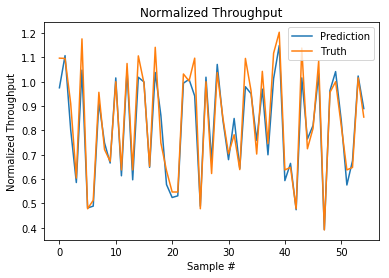

In [18]:
# fix random seed for reproducibility
seed_val = 1
from numpy.random import seed
seed(seed_val)
from tensorflow import set_random_seed
set_random_seed(seed_val)
import random as rn
rn.seed(seed_val)


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
regressor = Sequential()

# Adding the input layer and the first hidden layer
regressor.add(Dense(units=10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))

# Adding the hidden layer
regressor.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

# Adding the output layer
regressor.add(Dense(units=1, kernel_initializer='normal'))

# Compiling the ANN
regressor.compile(loss='mse', optimizer='sgd')



# Fitting the ANN to the Training set
# evaluate model with standardized dataset
history = regressor.fit(X_train, y_train, batch_size = 10, epochs = 1000, verbose=0, shuffle=False)

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = regressor.predict(X_test).flatten()
y_pred = sc_y.inverse_transform(y_pred)

# Evaluate the results
evaluate_results(y_test, y_pred)

In [20]:
# Visualization of the network
from keras.utils import plot_model
plot_model(regressor, show_shapes=True, to_file='model.png')

In [21]:
import time
class TimerClass:
    def __init__(self):
        self.start_time = time.time()

    def tic(self):
        self.start_time = time.time()

    def toc(self):
        elapsed = time.time() - self.start_time
        return elapsed

    def toc_print(self):
        elapsed = time.time() - self.start_time
        print('{:4.02f}'.format(elapsed))
        return elapsed


0.417527285489169
r2_score:  0.9308794786876395
MSE:  0.0034132099731981063
Correlation:  0.9704917307208194
ajd r2_score:  0.8902203485038981
RMSE:  0.058422683721291904
explained_variance_score:  0.9391824543593088


(0.9308794786876395, 0.0034132099731981063, 0.9391824543593088)

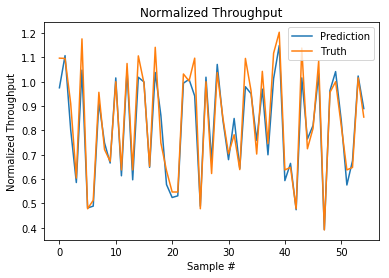

In [22]:
model_file_name = 'nn_tp.h5'
scaler_file_name_x = 'scaler_x.joblib'
scaler_file_name_y = 'scaler_y.joblib'

regressor.save(model_file_name)

from sklearn.externals import joblib

joblib.dump(sc_X, scaler_file_name_x)
joblib.dump(sc_y, scaler_file_name_y)

from keras.models import load_model
clf = load_model(model_file_name)
my_sc_X = joblib.load(scaler_file_name_x)
my_sc_y = joblib.load(scaler_file_name_y)

timer = TimerClass()
timer.tic()
# Predicting the Test set results
y_pred = clf.predict(X_test).flatten()
y_pred = my_sc_y.inverse_transform(y_pred)
print(timer.toc() * 1000 / len(y_pred))

# Evaluate the results
evaluate_results(y_test, y_pred)